In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
from plotly import graph_objs as go
from gensim.corpora import Dictionary
from gensim.corpora.bleicorpus import BleiCorpus

/home/dgarrido/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# load args
with open("../args.json", "r") as f:
    args = json.load(f)

In [3]:
# load similarity graph
path_graph = f'{args["results"]}graph/graph_{args["slice_type"]}.json'
with open(path_graph, "r") as f:
    graph = json.load(f)

In [4]:
def get_distances_from_graph(graph):
    distances = []
    slices = list(graph.keys())
    for slice in slices:
        I = list(graph[slice].keys())
        for i in I:
            topic_distances = graph[slice][i].values()
            for dist in topic_distances:
                distances.append(dist)
    distances = pd.Series(distances)
    return distances

In [5]:
def cum_dist(serie):
    cum_dist = []
    cum = 0
    sorted_serie = serie.sort_values(ascending=True)
    for elem in sorted_serie:
        cum+=elem
        cum_dist.append(cum)
    cum_dist = pd.Series([elem/cum_dist[-1] for elem in cum_dist])
    return cum_dist

In [6]:
distances = get_distances_from_graph(graph)
sorted_distances = pd.Series(distances).sort_values(ascending=True)
cum_dist = cum_dist(distances)

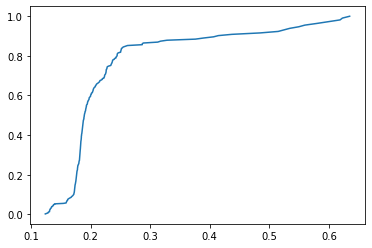

In [7]:
plt.plot(sorted_distances, cum_dist)

In [8]:
distances.describe()

count    330.000000
mean       0.206339
std        0.078789
min        0.124070
25%        0.176368
50%        0.185510
75%        0.208111
max        0.634835
dtype: float64

In [9]:
distances.quantile(q=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99])

0.05    0.134069
0.10    0.160475
0.20    0.174409
0.30    0.178360
0.40    0.182687
0.50    0.185510
0.60    0.189753
0.70    0.200068
0.80    0.223585
0.90    0.245253
0.95    0.323360
0.99    0.593283
dtype: float64

In [10]:
path_corpus = f'{args["corpus"]}{args["slice_type"]}'
dict_files = sorted([file for file in os.listdir(path_corpus) if ".dict" in file])
path_models = f'{args["results"]}hdp/{args["slice_type"]}'
models_dir = sorted(os.listdir(path_models))

slices = range(1, len(models_dir)+1)
data = {}
for slice in slices:
    # load dictionary {word->id}
    path_dict = f'{path_corpus}/{dict_files[slice-1]}'
    token2id = Dictionary.load(path_dict).token2id

    # load topics distributions
    path_topics = f'{path_models}/{models_dir[slice-1]}/mode-topics.dat'
    with open(path_topics, "r") as f:
        topics = np.array([[int(word) for word in line.strip().split()] for line in f])
    topics_dists = (topics.T/topics.sum(axis=1)).T

    #save data in a dict
    data[slice] = {"token2id": token2id, "topics_dists": topics_dists}

In [11]:
def get_topic_topn(data, topn):
    text_topn_words = []
    slices = list(data.keys())
    for slice in slices:
        token2id = data[slice]["token2id"]
        id2token = {v: k for k, v in token2id.items()}
        #for each (slice,i)
        for i, topic in enumerate(data[slice]["topics_dists"]):
            topn_ids = np.argsort(topic)[-topn:]
            topn_list = [id2token[id] for id in topn_ids]
            topn_str = "<br>".join(topn_list)
            text_topn_words.append(topn_str)
    return text_topn_words

In [12]:
def get_network_data(graph):
    
    # nodes
    slices = list(graph.keys())
    nodes = []
    for slice in slices:
        I = list(graph[slice].keys())
        for i in I:
            nodes.append([int(slice), int(i)])
    J = list(graph[slice][i].keys())
    for j in J:
        nodes.append([int(slice)+1, int(j)])
    nodes = np.array(nodes)
    
    # edges
    edges = []
    slices = list(graph.keys())
    for slice in slices:
        I = list(graph[slice].keys())
        for i in I:
            J = list(graph[slice][i].keys())
            for j in J:
                x  = [int(slice), int(slice)+1, None]
                y  = [int(i), int(j), None]
                similarity = graph[slice][i][j]
                edges.append((x, y, similarity))         
      
    return nodes, edges  

In [13]:
def make_edge(x, y, text, width):
    return  go.Scatter(x         = x,
                       y         = y,
                       line      = dict(width = width,
                                   color = 'cornflowerblue'),
                       hoverinfo = 'text',
                       text      = text,
                       mode      = 'lines')
def plot_network(nodes, text, edges, threshold):
    """
    """
    # create node trace
    node_trace = go.Scatter(x = nodes[:,0], y = nodes[:,1], text = text,
                        mode = 'markers',
                        hoverinfo = 'text',
                        marker = dict(
                            showscale = True,
                            colorscale = 'YlGnBu',
                            reversescale = True,
                            color = [],
                            size = 10,
                            colorbar = dict(
                                thickness = 15,
                                title = 'Node Connections',
                                xanchor = 'left',
                                titleside = 'right'
                            ),
                        line_width = 2))
    # create edge traces
    edge_trace = []
    for edge in edges:
        x = edge[0]
        y = edge[1]
        similarity = edge[2]
        if similarity >= threshold:
            trace = make_edge(x, y, f"{round(similarity,3)}", width = 2*similarity) 
            edge_trace.append(trace)
        
    # layout
    layout = go.Layout(
    paper_bgcolor='rgba(0,0,0,0)', 
    plot_bgcolor='rgba(0,0,0,0)', 
    xaxis =  {'showgrid': False, 'zeroline': False}, 
    yaxis = {'showgrid': False, 'zeroline': False},
    )
    # create figure
    fig = go.Figure(layout = layout)
    # add all edge traces
    for trace in edge_trace:
        fig.add_trace(trace)
    # add node trace
    fig.add_trace(node_trace)
    # remove legend
    fig.update_layout(showlegend = False)
    # tick labels
    fig.update_xaxes(showgrid=False, zeroline=False, showticklabels=True, tickvals=list(range(1,nodes.max()+1,1)))
    fig.update_yaxes(showticklabels = False)
    # show figure
    fig.show()


In [16]:
# network data
nodes, edges = get_network_data(graph)
text = get_topic_topn(data, 5)

KeyError: 3369

In [15]:
plot_network(nodes, text, edges, distances.quantile(0.2))

NameError: name 'text' is not defined